In [1]:
import os
import sys

import numpy as np
import pandas as pd 
import scipy.io as sio
import matplotlib.pyplot as plt

path = ("/home/alana/mg-results/046e17mv1/")
save_path = ("/home/alana/plots/mg_results/")

In [3]:
# run for interacting with database from ssh tunnel
import sys

sys.path.append("/home/tamara/Documents/DeepHumanVision_pilot/")
from data_base.db_setup import *

Please enter DataJoint username:  alana
Please enter DataJoint password:  ···············


Connecting alana@localhost:3306


In [4]:
channels = sio.loadmat(path + "channels.mat")
clus_info = sio.loadmat(path + "cluster_info.mat")

Load in CSC1_spikes file
- checking out the values in the mat-strx, only using the "index_ts" presently 
- "index_ts" are sorted into various clusters, where each spike time is assigned to a cluster
- the keys for the clusters are given in the corresponding times_*.mat files

In [5]:
csc_file = 6

csc = sio.loadmat(path + "CSC{}_spikes.mat".format(csc_file))
print("Mat file strx: ", csc.keys())
print("Setting csc var to just 'index_ts'.")
csc = csc["index_ts"]

print("")

times = sio.loadmat(path + "times_CSC{}.mat".format(csc_file)) 
times = times["cluster_class"]

print("Length csc unit file: {}".format(len(csc)))
print("Length time unit file: {}".format(len(times)))

Mat file strx:  dict_keys(['__header__', '__version__', '__globals__', 'spikes', 'index_ts'])
Setting csc var to just 'index_ts'.

Length csc unit file: 11565
Length time unit file: 11565


### Cluster key: 
- 1 = MU
- 2 = SU
- -1 = Artifact
- 0 = Unassigned (ignored)

In [6]:
print("Number and type of clusters for {}:  ".format(csc_file), clus_info['cluster_info'][0][csc_file - 1][0])

Number and type of clusters for 6:   [2 2]


### Load in corresponding unit from database

In [7]:
def get_unit_id(csc_nr, unit_type, unit_nr, patient_id):
    return ((ElectrodeUnits & "csc = '{}'".format(csc_nr) &  "patient_id = '{}'".format(patient_id)
            & "unit_id = '{}'".format(unit_type) & "unit_nr = '{}'".format(unit_nr)).fetch('unit_id'))[0]

In [8]:
ElectrodeUnit() & "patient_id='46'" & "csc='6'"

patient_id patient ID,unit_id unique ID for unit (for respective patient),csc number of CSC file,"unit_type unit type: 'M' for Multi Unit, 'S' for Single Unit, 'X': undefined","unit_nr number of unit, as there can be several multi units and single units in one CSC file",brain_region brain region where unit was recorded,additional_information space for additional information
46,4,6,S,1,LA,
46,5,6,S,2,LA,


In [9]:
name = (SpikeTimesDuringMovie & 'patient_id=46' & "unit_id=4" & "session_nr=1").fetch("spike_times")[0]
print(name)
unit1 = np.load(name)
os.remove(name)

name = (SpikeTimesDuringMovie & 'patient_id=46' & "unit_id=5" & "session_nr=1").fetch("spike_times")[0]
print(name)
unit2 = np.load(name)
os.remove(name)

CSC6_SUA1.npy
CSC6_SUA2.npy


In [10]:
print("All spike times in database unit also in loaded unit?", unit1.all() in csc)
print("All spike times in database unit also in loaded unit?", unit2.all() in csc)

All spike times in database unit also in loaded unit? False
All spike times in database unit also in loaded unit? False


In [11]:
labels = [row[0] for i,row in enumerate(times)]
print("Labels in csc file",set(labels))
print("Numbers beyond 0.0 correspond to the index of the CSC-respective cluster_info array.")

Labels in csc file {0.0, 1.0, 2.0}
Numbers beyond 0.0 correspond to the index of the CSC-respective cluster_info array.


In [12]:
unit2_only = [row[1] for i,row in enumerate(times) if row[0] == 2.0]
unit1_only = [row[1] for i,row in enumerate(times) if row[0] == 1.0]
un_only = [row[1] for i,row in enumerate(times) if row[0] == 0.0]
art_only = [row[1] for i,row in enumerate(times) if int(row[0]) == -1]

In [13]:
print("SUA1:", len(unit1_only))
print("SUA2:",len(unit2_only))
print("Unassigned:",len(un_only))
print("Artifacts:",len(art_only))
print("total:", (len(unit1_only) + len(unit2_only) + len(un_only) + len(art_only)))

print("")

print("db unit1:", len(unit1))
print("db unit2:", len(unit2))

print("")

print("M&G spike counts include activity outside of the movie playback.")

SUA1: 9450
SUA2: 804
Unassigned: 1311
Artifacts: 0
total: 11565

db unit1: 7090
db unit2: 724

M&G spike counts include activity outside of the movie playback.


In [73]:
def clip_to_playback(vector, rec_on, rec_off):
    playback_spks = []
    for j, val in enumerate(vector):
        if val >= rec_on and val <= rec_off:
            playback_spks.append(val)
            
    return playback_spks

def plot_vor_nach(unitvor, unitnach, db_unit, db_unit_nach=None, save=None, save_name=None):
    if db_unit_nach is None:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), sharex=True)

        ax1.eventplot(unitvor)
        ax1.set_title("M&G unit, before")
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.set_yticks([])

        ax2.eventplot(unitnach)
        ax2.set_title("M&G unit, after")
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_yticks([])

        ax3.eventplot(db_unit)
        ax3.set_title("DB unit")
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.set_yticks([])
        ax3.set_xlabel("Time, CPU/Spike time")
        
        if save:
            plt.savefig(os.path.join(save, save_name + ".svg"), format="svg", bbox_inches='tight')
            plt.savefig(os.path.join(save, save_name + ".png"), format="png", bbox_inches='tight')
        
    else:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,15), sharex=True)

        ax1.eventplot(unitvor)
        ax1.set_title("M&G unit, before")
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.set_yticks([])

        ax2.eventplot(unitnach)
        ax2.set_title("M&G unit, after")
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_yticks([])

        ax3.eventplot(db_unit)
        ax3.set_title("DB unit")
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)
        ax3.set_yticks([])
        
        ax4.eventplot(db_unit_nach)
        ax4.set_title("DB unit after")
        ax4.spines['top'].set_visible(False)
        ax4.spines['right'].set_visible(False)
        ax4.set_yticks([])
        ax4.set_xlabel("Time, CPU/Spike time")
        
        if save:
            plt.savefig(os.path.join(save, save_name + ".svg"), format="svg", bbox_inches='tight')
            plt.savefig(os.path.join(save, save_name + ".png"), format="png", bbox_inches='tight')
            
    plt.show()
    
def compare_arts(db_unit, mg_unit):
    arts = []
    art_only = []
    for i, val in enumerate(db_unit):
        if (val in mg_unit) is False:
            arts.append((i,val))
            art_only.append(val)
    return arts, art_only

def mk_comparison_vec(main_vec, sub_vec):
    arts_vec = []
    
    for i, val in enumerate(sub_vec):
        if (val in main_vec) is False: 
            arts_vec.append(0)
        else:
            arts_vec.append(1)
    return arts_vec

### Loading in patient data in order to clip the marcel/gert results to just the movie playback portions

In [15]:
patient_id = 46
session_nr = 1

pts_patient = get_pts_of_patient(patient_id, session_nr)
neural_rec_time = get_neural_rectime_of_patient(patient_id, session_nr)
nrect = neural_rec_time / 1000

rec_on = nrect[0]
rec_off = nrect[-1]

unit1_mg_mv = clip_to_playback(unit1_only, rec_on, rec_off)
unit2_mg_mv = clip_to_playback(unit2_only, rec_on, rec_off)

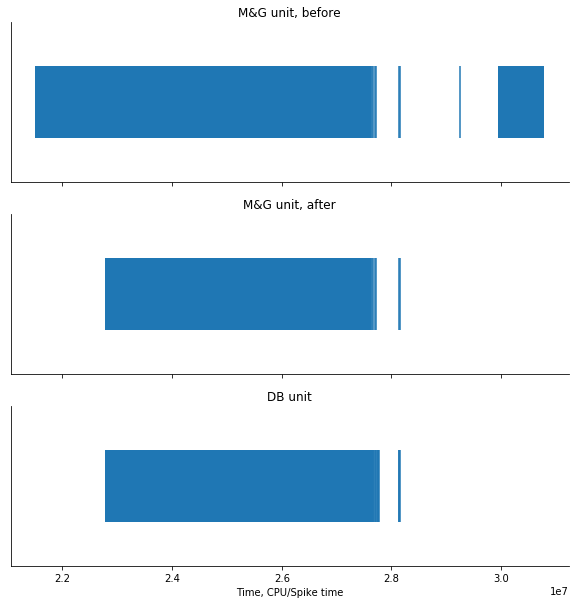

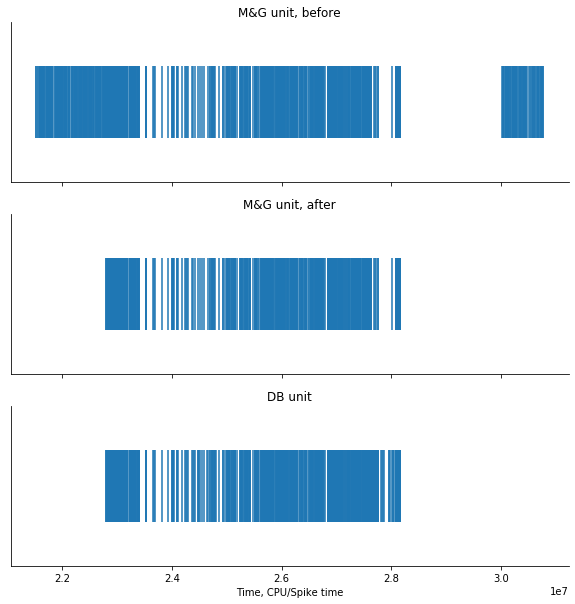

In [16]:
## before and after clipping M&G's data to just the movie 
plot_vor_nach(unit1_only, unit1_mg_mv, unit1) #, save=save_path, save_name="csc6_1_movieclip")
plot_vor_nach(unit2_only, unit2_mg_mv, unit2) #, save=save_path, save_name="csc6_2_movieclip")

### Determine which spikes were flagged as artifacts in M&G's algorithm (those in our data but not in their's)
#### "master list" -- artspk* 

In [17]:
arts1, artspk1 = compare_arts(unit1, unit1_mg_mv) # arts1 = tuple with index, and removed spike; artspk1 = just the spikes 
arts2, artspk2 = compare_arts(unit2, unit2_mg_mv)

In [18]:
len(unit1_mg_mv) + len(unit2_mg_mv)

6931

In [19]:
len(unit1) + len(unit2) - (len(arts2) + len(arts1))

6931

# same artifacts? progressing through our pipeline, seeing if M&G's artifact-spikes coincide


## Pause Handling

In [20]:
sys.path.append("/home/alana/DeepHumanVision_pilot/data_preprocessing/")
import pause_handling as ph
import data_utils as du

pat_id = 46

# path to patient watchlogs
path_wl = ('/home/alana/DeepHumanVision_pilot/data_preprocessing/patient_data/46/ffplay-watchlog-20151212-193220.log')

path_events = '/home/tamara/Documents/DeepHumanVision_pilot/data_base/data/patient_data/46/event_file/Events.nev'

path_daqlog = '/home/alana/DeepHumanVision_pilot/data_preprocessing/patient_data/46/timedDAQ-log-20151212-193106.log'

Pull pause information from the watchlog/patient meta data and then use 

In [60]:
TimeClass = du.TimeConversion(path_wl, path_daqlog, path_events)
start, stop = TimeClass.convert_pauses() #start : vector of pause start times; stop: corresponding pause stop times

Min Daq Diff: 1.1 ms, Max Daq Diff: 5.0 ms
Maximum Error after Event fit: 1.9 ms


In [61]:
ph_start = start
ph_stop  = stop

In [23]:
unit1_mg_ph, mgph_rm1 = ph.rm_pauses_spikes(unit1_mg_mv, start, stop, return_intervals=True)
unit2_mg_ph, mgph_rm2 = ph.rm_pauses_spikes(unit2_mg_mv, start, stop, return_intervals=True)

unit1_db_ph, dbph_rm1 = ph.rm_pauses_spikes(unit1, start, stop, return_intervals=True)
unit2_db_ph, dbph_rm2 = ph.rm_pauses_spikes(unit2, start, stop, return_intervals=True)

ph1_spks = unit1[dbph_rm1]
ph2_spks = unit2[dbph_rm2]

In [24]:
#_, ph1_arts = compare_arts(unit1_db_ph, unit1_mg_ph)
#_, ph2_arts = compare_arts(unit2_db_ph, unit2_mg_ph)
#assert (len(unit1_db_ph) - len(ph1_arts)) == len(unit1_mg_ph)

_, ph1_arts = compare_arts(unit1, unit1_db_ph)
_, ph2_arts = compare_arts(unit2_db_ph, unit2)

_, ph1_arts_db = compare_arts(ph1_arts, artspk1)

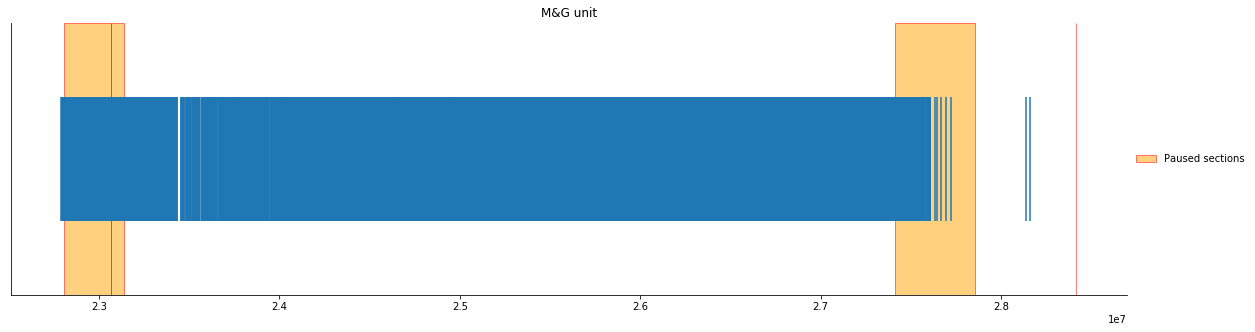

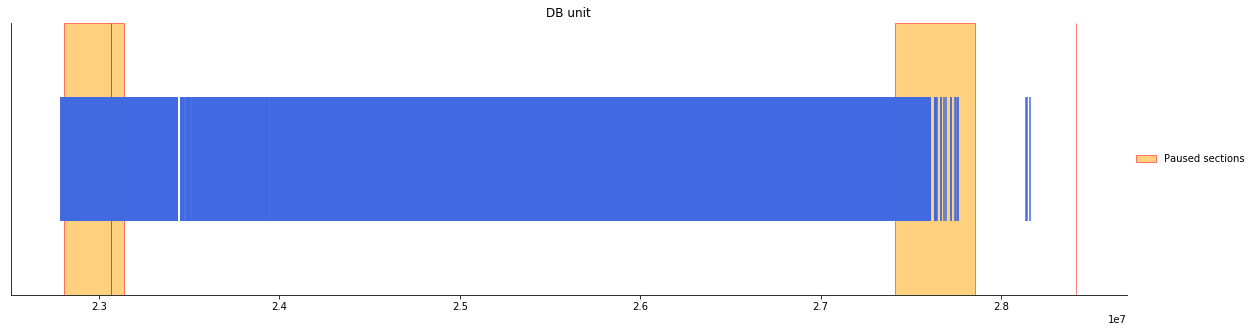

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(unit1_mg_mv)
ax1.set_title("M&G unit")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label='Paused sections')
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_1_pausewhole"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(unit1, color="royalblue")
ax1.set_title("DB unit")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label='Paused sections')
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_2_pausewhole"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

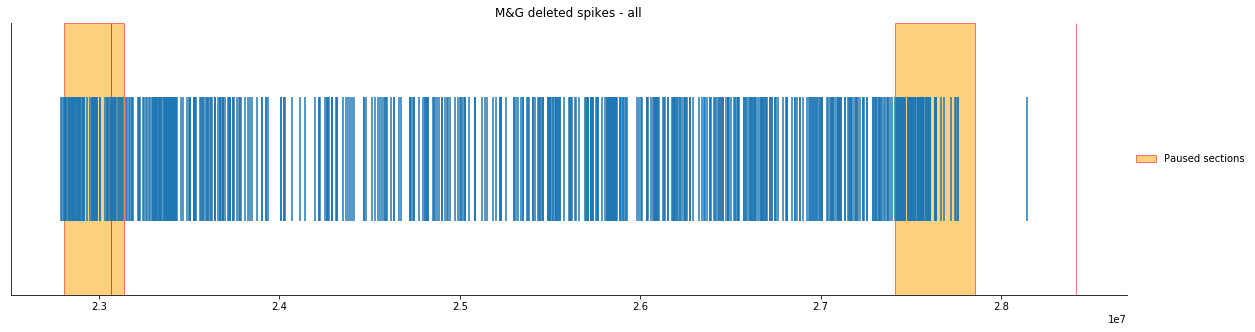

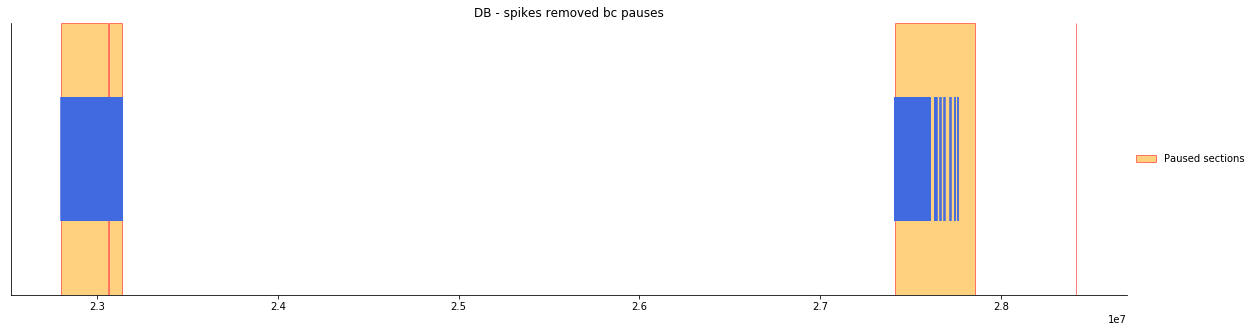

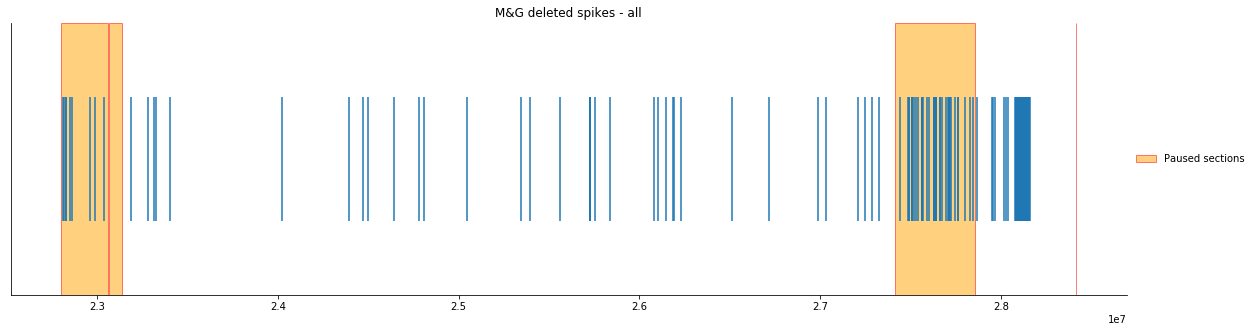

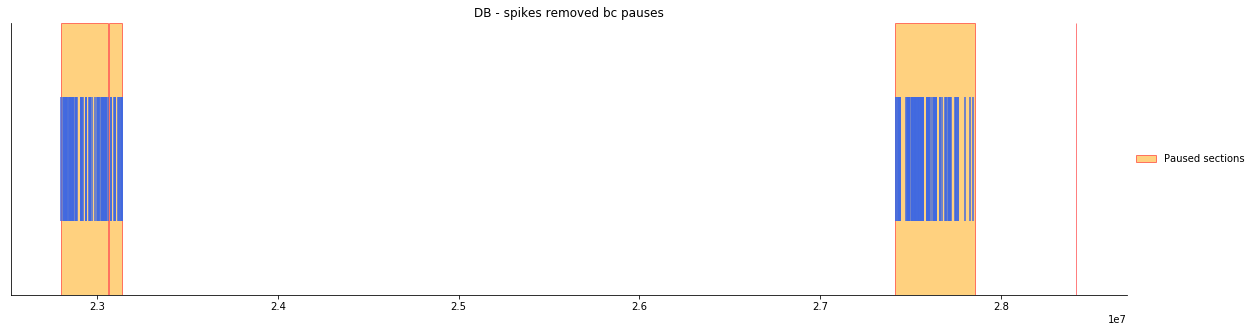

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(artspk1)
ax1.set_title("M&G deleted spikes - all")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label='Paused sections')
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_1_MGpauseart"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(ph1_spks, color="royalblue")
ax1.set_title("DB - spikes removed bc pauses")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label='Paused sections')
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)


# save_name = "csc6_1_DBpauseart"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')



fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(artspk2)
ax1.set_title("M&G deleted spikes - all")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label='Paused sections')
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)


# save_name = "csc6_2_MGpauseart"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')



fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(ph2_spks, color="royalblue")
ax1.set_title("DB - spikes removed bc pauses")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label='Paused sections')
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)


# save_name = "csc6_2_DBpauseart"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


In [27]:
shared_arts_ph1 = list(set(ph1_spks).intersection(artspk1))
shared_arts_ph2 = list(set(ph2_spks).intersection(artspk2))

print("Units 1 & 2")
print("Total unit1 M&G artifacts: ", len(artspk1))
print("Total unit1 spikes removed from pause handling: ", len(ph1_spks))

print("M&G artifacts also removed from pause handling: ",  len(shared_arts_ph1))
print("")

print("Total unit2 M&G artifacts: ", len(artspk2))
print("Total unit2 spikes removed from pause handling: ", len(ph2_spks))

print("M&G artifacts also removed from pause handling: ",  len(shared_arts_ph2))

Units 1 & 2
Total unit1 M&G artifacts:  714
Total unit1 spikes removed from pause handling:  921
M&G artifacts also removed from pause handling:  161

Total unit2 M&G artifacts:  169
Total unit2 spikes removed from pause handling:  186
M&G artifacts also removed from pause handling:  65


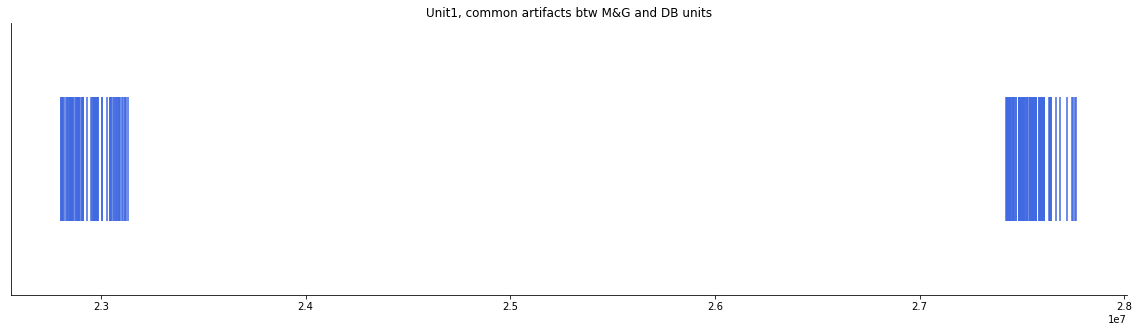

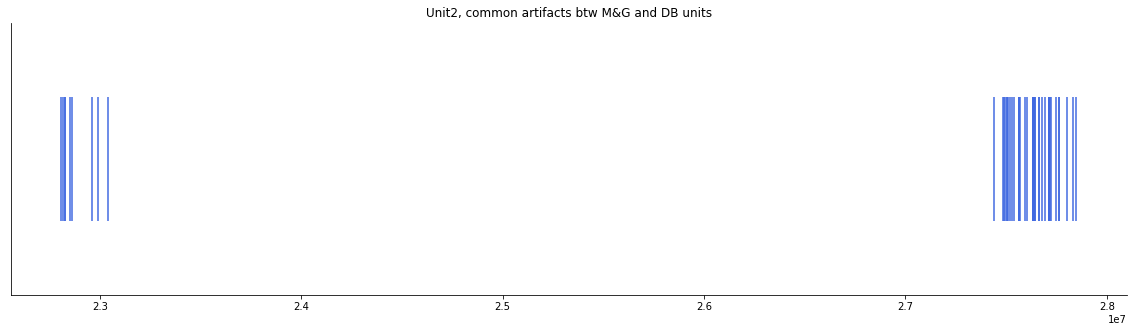

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(shared_arts_ph1, color="royalblue")
ax1.set_title("Unit1, common artifacts btw M&G and DB units")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

# save_name = "csc6_1_commonarts"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(shared_arts_ph2, color="royalblue")
ax1.set_title("Unit2, common artifacts btw M&G and DB units")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

# save_name = "csc6_2_commonarts"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

## Summed Spikes artifact removal

Two levels:
- Unit level
- **Patient level** -- only doing patient level at the moment

Both: isolate bins for which the firing rate exceeded 4 stds of the baseline (baseline calculated for whole patient data or unit-level)

In [29]:
## Unit level summed spikes 

## first, bin spikes 

bins = 1000 # define bin size in msec

total_msec = rec_off - rec_on 
total_bins = int(total_msec / bins)
bins = np.linspace(rec_on, rec_off, total_bins)

## bin M&G units
unit1_mg_mv_bin1000, bin1 = np.histogram(unit1_mg_mv, bins=bins)
unit2_mg_mv_bin1000, bin2 = np.histogram(unit2_mg_mv, bins=bins)


## load in DB units
patient_id = 46
session_nr = 1
bin_size = 1000

unit_id = 4
spikes1 = (BinnedSpikesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id) & "bin_size='{}'".format(bin_size)).fetch("spike_vector")[0]

unit1_db_bin1000 = np.load(spikes1)

unit_id = 5
spikes2 = (BinnedSpikesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id) & "bin_size='{}'".format(bin_size)).fetch("spike_vector")[0]

unit2_db_bin1000 = np.load(spikes2)


os.remove(spikes1)
os.remove(spikes2)

### Compare binned data between Gert & Marcel's data and that in the database

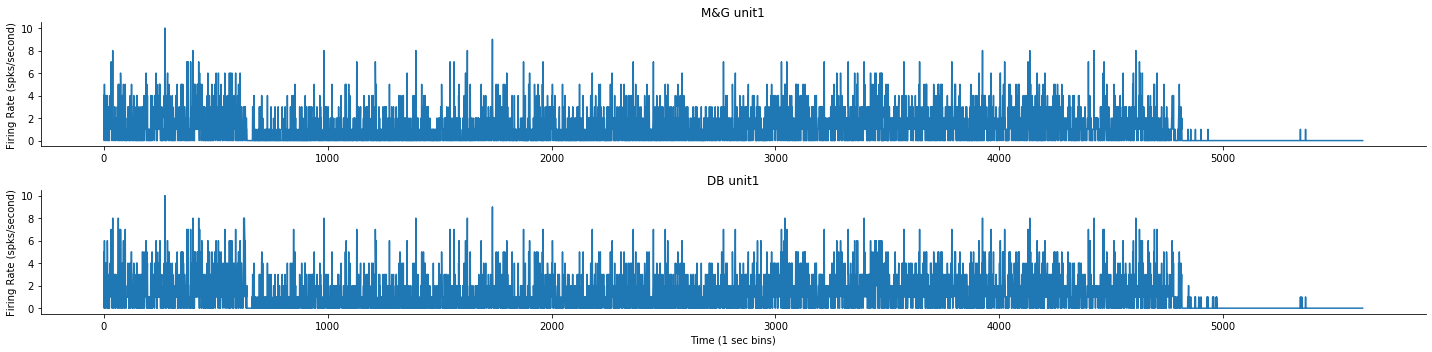

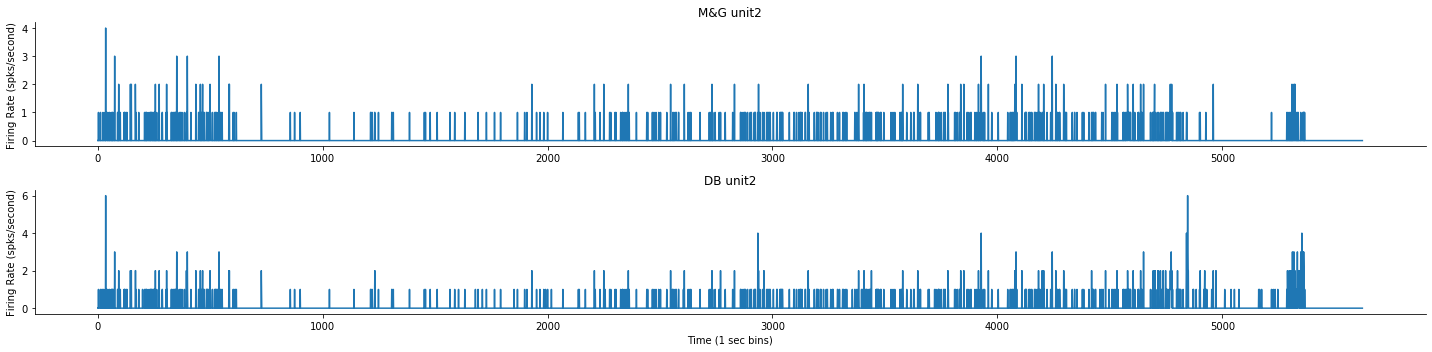

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,5))

ax1.plot(unit1_mg_mv_bin1000)
ax1.set_title("M&G unit1")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/second)")

ax2.plot(unit1_db_bin1000)
ax2.set_title("DB unit1")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (1 sec bins)")
ax2.set_ylabel("Firing Rate (spks/second)")

fig.tight_layout()

# save_name = "csc6_1_binned1000"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,5))

ax1.plot(unit2_mg_mv_bin1000)
ax1.set_title("M&G unit2")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/second)")

ax2.plot(unit2_db_bin1000)
ax2.set_title("DB unit2")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (1 sec bins)")
ax2.set_ylabel("Firing Rate (spks/second)")

fig.tight_layout()

# save_name = "csc6_2_binned1000"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

In [31]:
def artifact_vector_n_stddev(spikes_to_be_processed, nr_std_devs):
    mean_value = np.mean(spikes_to_be_processed)
    std_value = np.std(spikes_to_be_processed)
    return [0 if x > mean_value + nr_std_devs * std_value else 1 for x in spikes_to_be_processed]

def get_spiking_activity_cleaned_patient_level_bin1000(patient_id, session_nr, unit_id, cleaning_vector):
    """
    return the firing rates (binned at 1s) after patient level data cleaning was applied
    :param patient_id: ID of patient
    :param session_nr: session number
    :param cleaning_vector: vector to clean data with (0s and 1s)
    :param unit_id: Unit ID of which spiking activity shall be extracted
    """
    bin_size = 1000
    spikes = (BinnedSpikesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id) & "bin_size='{}'".format(bin_size)).fetch("spike_vector")[
        0]

    spike_vec = np.load(spikes)
    clean_spikes = spike_vec[np.where(cleaning_vector == 1)]

    if os.path.exists(spikes):
        os.remove(spikes)

    return clean_spikes


def get_sum_all_spikes_mg_data(file_path, type_prefix, bin_size, rec_on, rec_off):
    
    spikes = []
    
    for filename in os.listdir(file_path):
            if filename.startswith(type_prefix):
                #binary = np.load(os.path.join(path_binaries, str(pat_id), filename))    
                
                times = sio.loadmat(os.path.join(file_path, filename)) 
                times = times["cluster_class"]
                
                #separate out non-artifact spikes (currently not concerned with whether they are clustered into separate units)
                all_unit_spks = []
                for i, pair in enumerate(times):
                    if int(pair[0]) > 0:
                        all_unit_spks.append(pair[1])
                
                # clip to just playback activity 
                all_unit_mv = clip_to_playback(all_unit_spks, rec_on, rec_off)
                
                total_msec = rec_off - rec_on 
                total_bins = int(total_msec / bin_size)
                bins = np.linspace(rec_on, rec_off, total_bins)

                ## bin M&G units
                all_unit_mv_bin1000, _ = np.histogram(all_unit_mv, bins=bins)
                
                spikes.append(all_unit_mv_bin1000)
                
    return [sum(row[i] for row in spikes) for i in range(len(spikes[0]))]
                        
def get_sum_all_spikes(patient_id, session_nr, bin_size):
    vec_names = (BinnedSpikesDuringMovie() & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "bin_size='{}'".format(bin_size)).fetch("spike_vector")
    spikes = []
    for name_one_file in vec_names:
        spikes.append(np.load(name_one_file))
        os.remove(name_one_file)
    return [sum(row[i] for row in spikes) for i in range(len(spikes[0]))]

In [32]:
file_path = "/home/alana/mg-results/046e17mv1/"
type_prefix = "times"
bin_size = 1000

sum46_mg = get_sum_all_spikes_mg_data(file_path, type_prefix, bin_size, rec_on, rec_off)

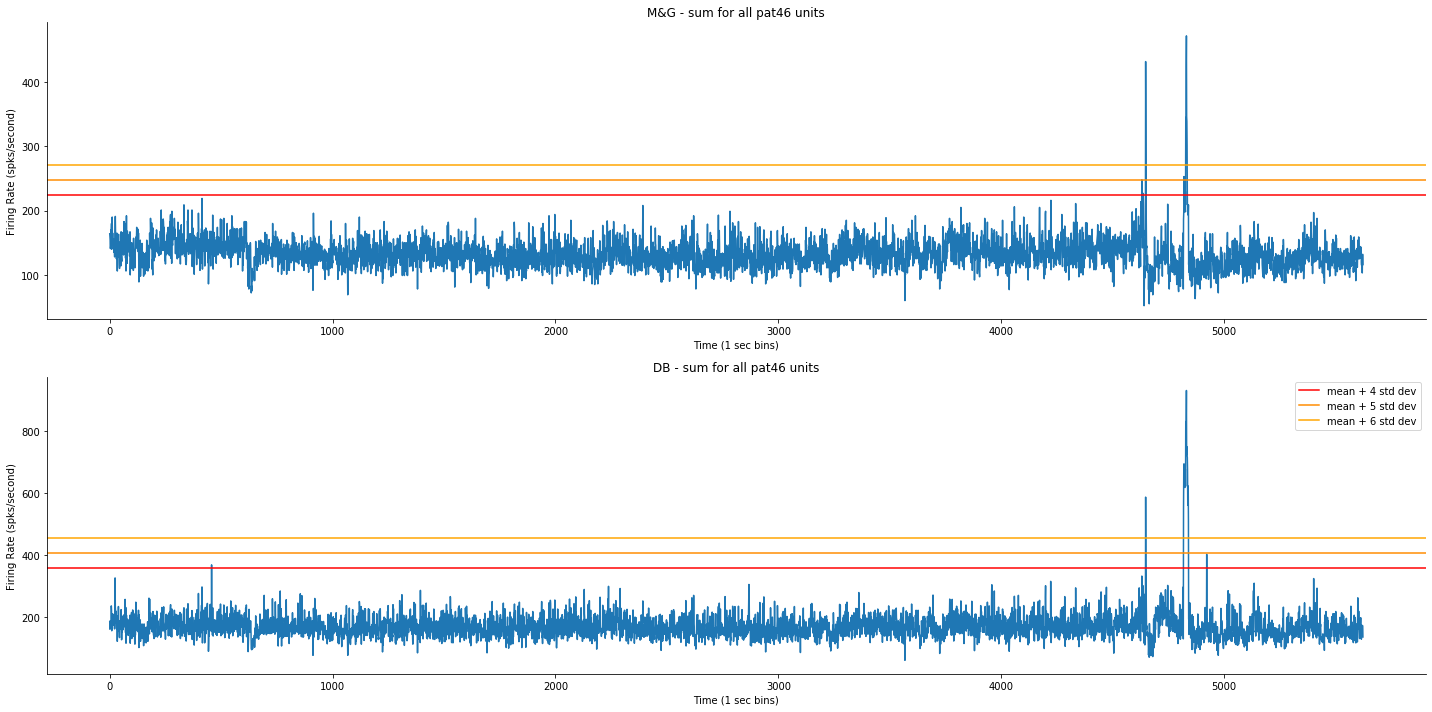

In [33]:
sum46 = get_sum_all_spikes(46, 1, 1000)
mean_46 = np.mean(sum46)
std_46 = np.std(sum46)
cut_off = mean_46 + 4*std_46

mean_46mg = np.mean(sum46_mg)
std_46mg = np.std(sum46_mg)
cut_offmg = mean_46mg + 4*std_46mg


fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(20,10))

# m&g data
ax2.plot(sum46_mg)
ax2.set_title("M&G - sum for all pat46 units")
ax2.axhline(y=cut_offmg, color="red", label="mean + 4 std dev")
ax2.axhline(y=mean_46mg + 5*std_46mg, color="darkorange", label="mean + 5 std dev")
ax2.axhline(y=mean_46mg + 6*std_46mg, color="orange", label="mean + 6 std dev")

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (1 sec bins)")
ax2.set_ylabel("Firing Rate (spks/second)")

# db data
ax1.plot(sum46)
ax1.set_title("DB - sum for all pat46 units")
ax1.axhline(y=cut_off, color="red", label="mean + 4 std dev")
ax1.axhline(y=mean_46 + 5*std_46, color="darkorange", label="mean + 5 std dev")
ax1.axhline(y=mean_46 + 6*std_46, color="orange", label="mean + 6 std dev")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/second)")

plt.tight_layout()
plt.legend()

# save_name = "sum_spks"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

Get spike time corresponding to the bins which exceed the threshold activity level

In [34]:
# indicator function for bins which have activity 4 stds from the mean 
sum_art_46 = artifact_vector_n_stddev(sum46, 4)

# get times for the edges of the artifact bins
bins = bins
vec = sum_art_46

bin_start = []
bin_stop = []

for ind, val in enumerate(vec):
    if val == 0: 
        bin_start.append(bins[ind])
        bin_stop.append(bins[ind + 1])
        
        
assert (len(vec) - sum(vec)) == len(bin_start)

In [35]:
# re-assigning start/stop variables to bin start/stops (previously pauses)
start = bin_start
stop  = bin_stop

unit1_db_ss, dbss_rm1 = ph.rm_pauses_spikes(unit1, start, stop, return_intervals=True)
unit2_db_ss, dbss_rm2 = ph.rm_pauses_spikes(unit2, start, stop, return_intervals=True)

ss1_spks = unit1[dbss_rm1]
ss2_spks = unit2[dbss_rm2]

shared_arts_ss1 = list(set(ss1_spks).intersection(artspk1))
shared_arts_ss2 = list(set(ss2_spks).intersection(artspk2))

print("Units 1 & 2")
print("Total unit1 M&G artifacts: ", len(artspk1))
print("Total unit1 spikes removed from sum-spike filtering: ", len(ss1_spks))
print("M&G artifacts also removed from sum-spike filtering: ",  len(shared_arts_ss1))
print("")

print("Total unit2 M&G artifacts: ", len(artspk2))
print("Total unit2 spikes removed from sum-spike filtering: ", len(ss2_spks))
print("M&G artifacts also removed from sum-spike filtering: ",  len(shared_arts_ss2))

Units 1 & 2
Total unit1 M&G artifacts:  714
Total unit1 spikes removed from sum-spike filtering:  0
M&G artifacts also removed from sum-spike filtering:  0

Total unit2 M&G artifacts:  169
Total unit2 spikes removed from sum-spike filtering:  5
M&G artifacts also removed from sum-spike filtering:  4


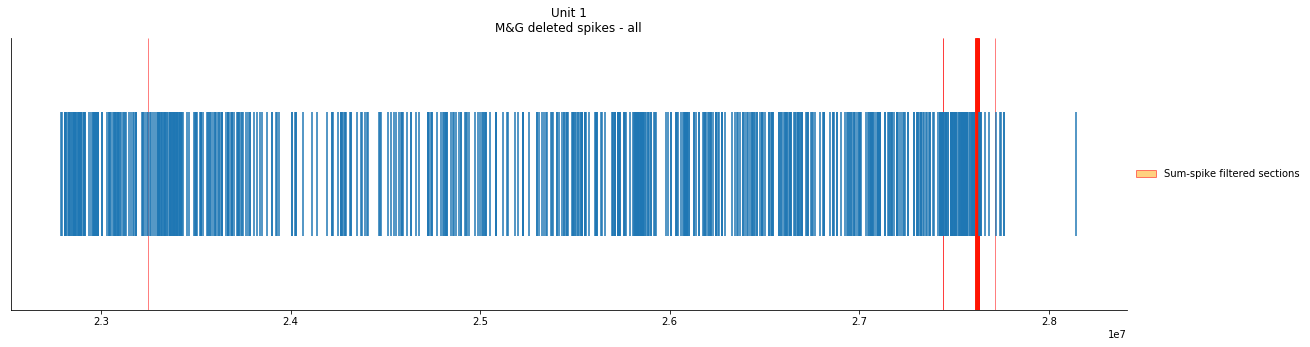

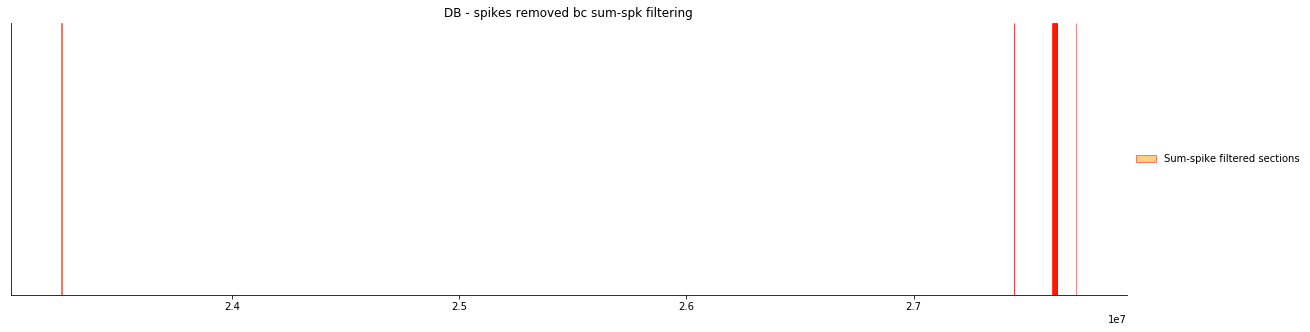

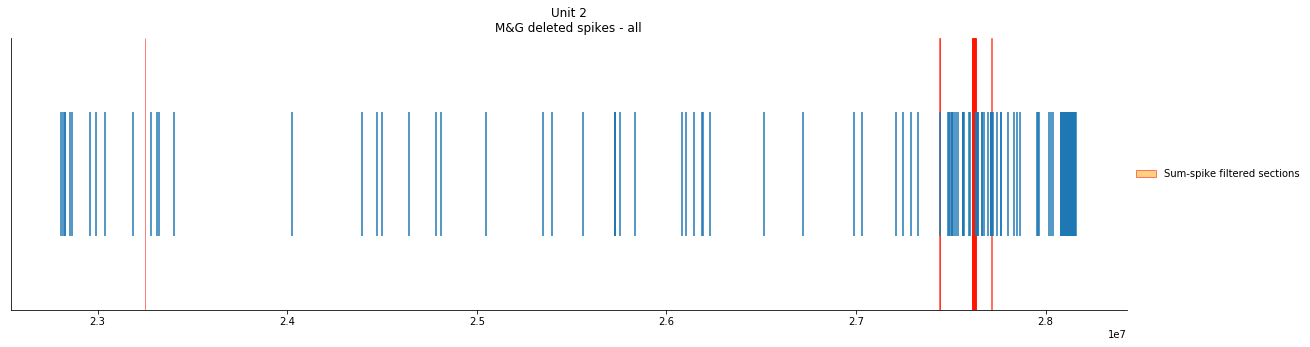

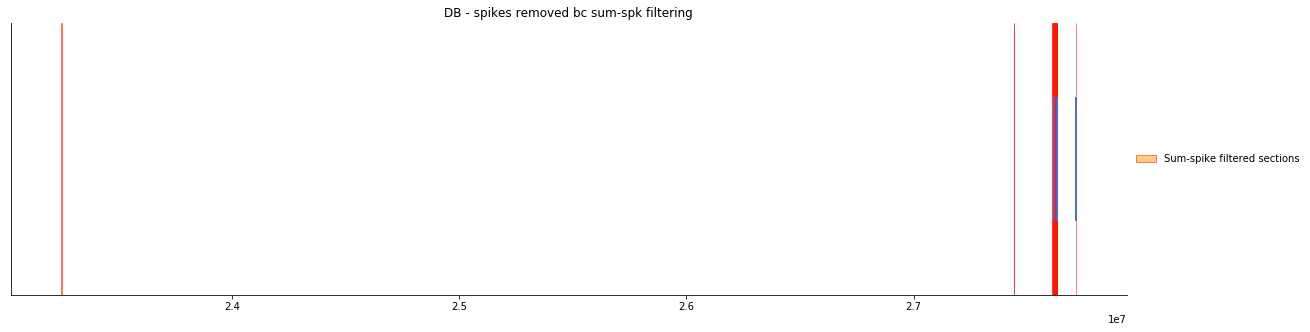

In [36]:
label = "Sum-spike filtered sections"

fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

unitnr = 1

ax1.eventplot(artspk1)
ax1.set_title("Unit {}\nM&G deleted spikes - all".format(unitnr))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_1_MGsumspk"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(ss1_spks, color="royalblue")
ax1.set_title("DB - spikes removed bc sum-spk filtering")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_1_DBsumspk"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')



fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

unitnr = 2

ax1.eventplot(artspk2)
ax1.set_title("Unit {}\nM&G deleted spikes - all".format(unitnr))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_2_MGsumspk"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')



fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(ss2_spks, color="royalblue")
ax1.set_title("DB - spikes removed bc sum-spk filtering")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_2_DBsumspk"
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

## Continuous watch artifacts

Beyond pauses, the movie playback can be further interrupted. 
We define a continuous watch vector based on the pts (frames) sequence from the patient's watchlog. 
So far, we've done this on a bin-by-bin basis. 

In [37]:
import clip_to_cont as clip 

sys.path.append("/home/alana/DeepHumanVision_pilot/data_preprocessing/")
from data_base.db_setup import *
import data_preprocessing.smoothing as smoothing
import data_preprocessing.artifact_detection as artifact_detection
import data_preprocessing.pause_handling as pause_handling
import data_preprocessing.binning as binning
import data_preprocessing.create_vectors_from_time_points as vecs

In [38]:
def make_binary(vector):
    binary = []
    for j, x in enumerate(vector):
        if x == 0: 
            binary.append(0)
        else:
            binary.append(1)
    return binary

In [39]:
# # load in continuous watch vectors
# cont_watch_10 = np.load("/home/alana/DeepHumanVision_pilot/tmp/patient_level_data_cleaning/46/cont_watch_{}_bin10.npy".format(patient_id)) # bin size 10
# cont_watch_100 = np.load("/home/alana/DeepHumanVision_pilot/tmp/patient_level_data_cleaning/46/cont_watch_{}_bin100.npy".format(patient_id)) # bin size 100

### new binning procedure
patient_id = 46
session_nr = 1
unit_id = 4
bin_size = 100
annotator_id = "p5"
annotation_date = "2020-02-02"
label_name = "tom"

neural_rec_time = get_neural_rectime_of_patient(patient_id, session_nr) / 1000
annotator_id_cont_watch = "p5"
annotation_date_cont_catch = "2020-03-23"

values_cont_watch, start_times_cont_watch, stop_times_cont_watch = get_info_continuous_watch_segments(patient_id, session_nr, annotator_id_cont_watch, annotation_date_cont_catch)

start_times_pauses, stop_times_pauses = get_start_stop_times_pauses(patient_id, session_nr)
rec_on = neural_rec_time[0]
rec_off = neural_rec_time[-1]
total_msec = rec_off - rec_on
total_bins = int(total_msec / bin_size)
bins = np.linspace(rec_on, rec_off, total_bins)
## not removing pauses at the moment
#bins_no_pauses = pause_handling.rm_pauses_bins(bins, start_times_pauses, stop_times_pauses) 

#cont_watch_100 = create_vectors_from_time_points.create_vector_from_start_stop_times_reference(bins_no_pauses, values_cont_watch[0], start_times_cont_watch[0], stop_times_cont_watch[0])
##

cont_watch_100 = vecs.create_vector_from_start_stop_times_reference(bins, values_cont_watch[0], start_times_cont_watch[0], stop_times_cont_watch[0])


### 10
bin_size = 10
total_bins = int(total_msec / bin_size)
bins = np.linspace(rec_on, rec_off, total_bins)

cont_watch_10 = vecs.create_vector_from_start_stop_times_reference(bins, values_cont_watch[0], start_times_cont_watch[0], stop_times_cont_watch[0])


## push to binary function
cont_watch_100bi = make_binary(cont_watch_100)
cont_watch_10bi  = make_binary(cont_watch_10)

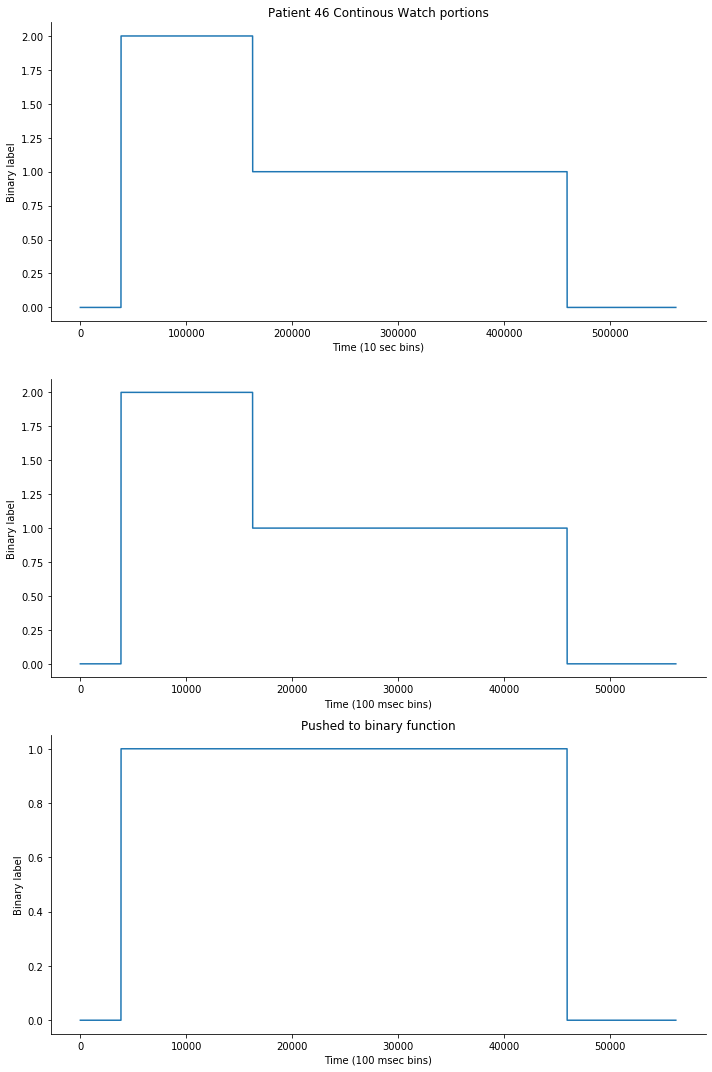

In [40]:
#fig, (ax2, ax3, ax1) = plt.subplots(3, 1, figsize=(10,10))

fig, (ax1, ax2,  ax3) = plt.subplots(3, 1, figsize=(10,15))

ax1.plot(cont_watch_10)
ax1.set_title("Patient {} Continous Watch portions".format(patient_id))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel("Time (10 sec bins)")
ax1.set_ylabel("Binary label")

ax2.plot(cont_watch_100)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (100 msec bins)")
ax2.set_ylabel("Binary label")

ax3.plot(cont_watch_100bi)
ax3.set_title("Pushed to binary function")

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel("Time (100 msec bins)")
ax3.set_ylabel("Binary label")

# # db data
# ax1.plot(cont_watch_100)
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.set_xlabel("Time (100 sec bins)")
# ax1.set_ylabel("Binary label")

plt.tight_layout()
plt.show()

In [41]:
# bin to 100 and 10 msec

### 100 ###
bins = 100 # define bin size in msec
total_msec = rec_off - rec_on 
total_bins = int(total_msec / bins)
bins = np.linspace(rec_on, rec_off, total_bins)

## bin M&G units
unit1_mg_mv_bin100, bin1 = np.histogram(unit1_mg_mv, bins=bins)
unit2_mg_mv_bin100, bin2 = np.histogram(unit2_mg_mv, bins=bins)


## load in DB units
patient_id = 46
session_nr = 1
bin_size = 100

unit_id = 4
spikes1 = (BinnedSpikesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id) & "bin_size='{}'".format(bin_size)).fetch("spike_vector")[
        0]

unit1_db_bin100 = np.load(spikes1)

unit_id = 5
spikes2 = (BinnedSpikesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id) & "bin_size='{}'".format(bin_size)).fetch("spike_vector")[
        0]

unit2_db_bin100 = np.load(spikes2)
os.remove(spikes1)
os.remove(spikes2)

### 10 ###
bins = 10 # define bin size in msec
total_msec = rec_off - rec_on 
total_bins = int(total_msec / bins)
bins = np.linspace(rec_on, rec_off, total_bins)

## bin M&G units
unit1_mg_mv_bin10, bin1 = np.histogram(unit1_mg_mv, bins=bins)
unit2_mg_mv_bin10, bin2 = np.histogram(unit2_mg_mv, bins=bins)


## load in DB units
patient_id = 46
session_nr = 1
bin_size = 10

unit_id = 4
spikes1 = (SpikeTimesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id)).fetch("spike_times")[0]


unit1_db_spks = np.load(spikes1)
unit1_db_bin10, _ = np.histogram(unit1_db_spks, bins=bins)

unit_id = 5
spikes2 = (SpikeTimesDuringMovie & "patient_id='{}'".format(patient_id) & "session_nr='{}'".format(
        session_nr) & "unit_id='{}'".format(unit_id)).fetch("spike_times")[0]


unit2_db_spks = np.load(spikes2)
unit2_db_bin10, _ = np.histogram(unit2_db_spks, bins=bins)

os.remove(spikes1)
os.remove(spikes2)

# clipping activity to continuous watch portions

### 100 ###
unit1_mg_clip100, unit1_mg_ind_clipped100, unit1_mg_rm_bins100, unit1_mg_ind_rm_bins100 = clip.clip_array(unit1_mg_mv_bin100, cont_watch_100bi)
unit1_db_clip100, unit1_db_ind_clipped100, unit1_db_rm_bins100, unit1_db_ind_rm_bins100 = clip.clip_array(unit1_db_bin100, cont_watch_100bi)

unit2_mg_clip100, unit2_mg_ind_clipped100, unit2_mg_rm_bins100, unit2_mg_ind_rm_bins100 = clip.clip_array(unit2_mg_mv_bin100, cont_watch_100bi)
unit2_db_clip100, unit2_db_ind_clipped100, unit2_db_rm_bins100, unit2_db_ind_rm_bins100 = clip.clip_array(unit2_db_bin100, cont_watch_100bi)

### 10 ###
unit1_mg_clip10, unit1_mg_ind_clipped10, unit1_mg_rm_bins10, unit1_mg_ind_rm_bins10 = clip.clip_array(unit1_mg_mv_bin10, cont_watch_10bi)
unit1_db_clip10, unit1_db_ind_clipped10, unit1_db_rm_bins10, unit1_db_ind_rm_bins10 = clip.clip_array(unit1_db_bin10, cont_watch_10bi)

unit2_mg_clip10, unit2_mg_ind_clipped10, unit2_mg_rm_bins10, unit2_mg_ind_rm_bins10 = clip.clip_array(unit2_mg_mv_bin10, cont_watch_10bi)
unit2_db_clip10, unit2_db_ind_clipped10, unit2_db_rm_bins10, unit2_db_ind_rm_bins10 = clip.clip_array(unit2_db_bin10, cont_watch_10bi)

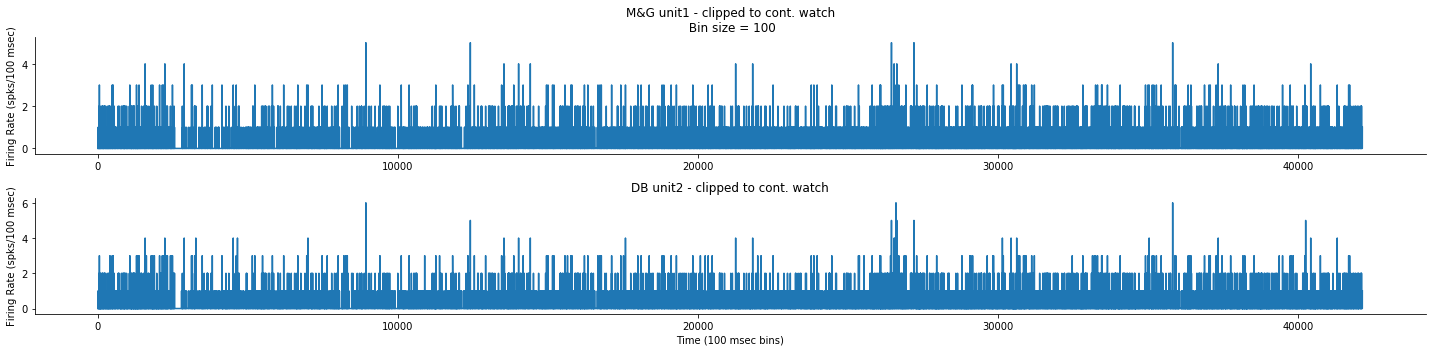

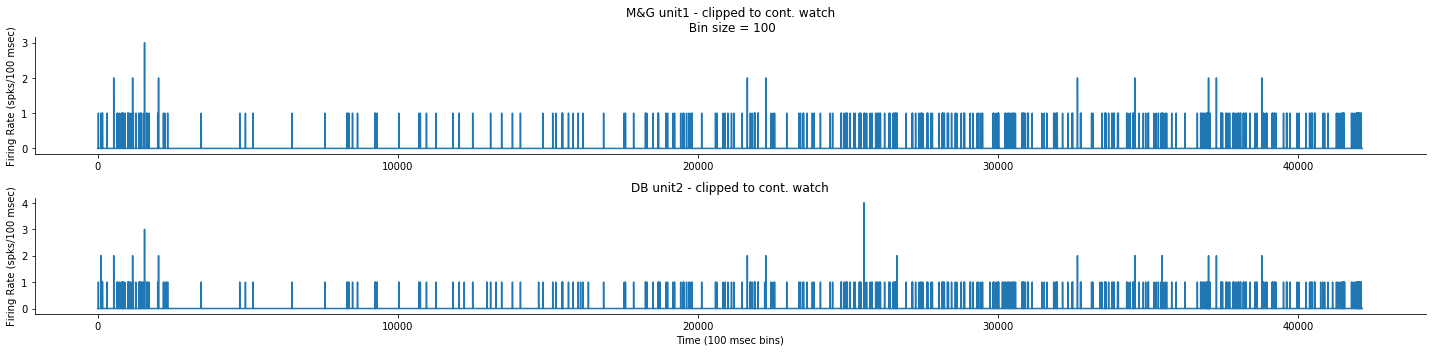

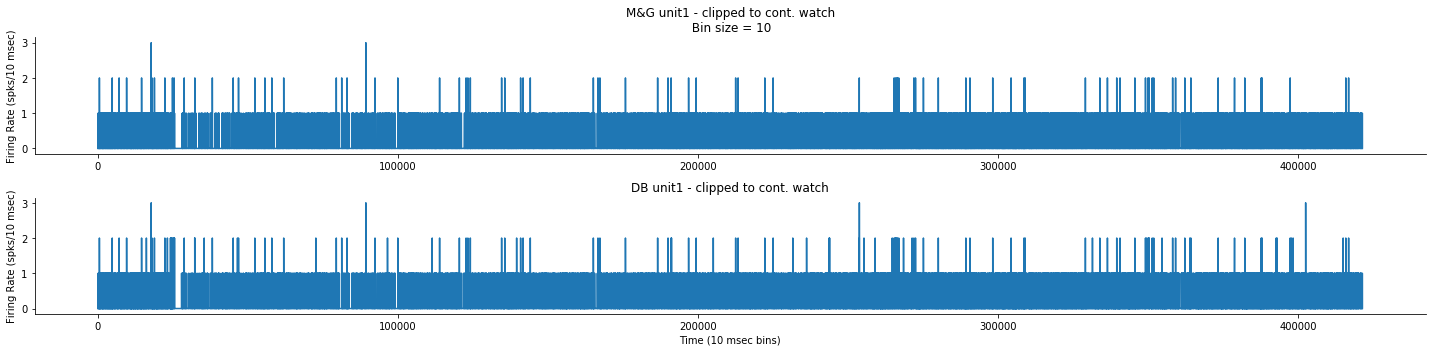

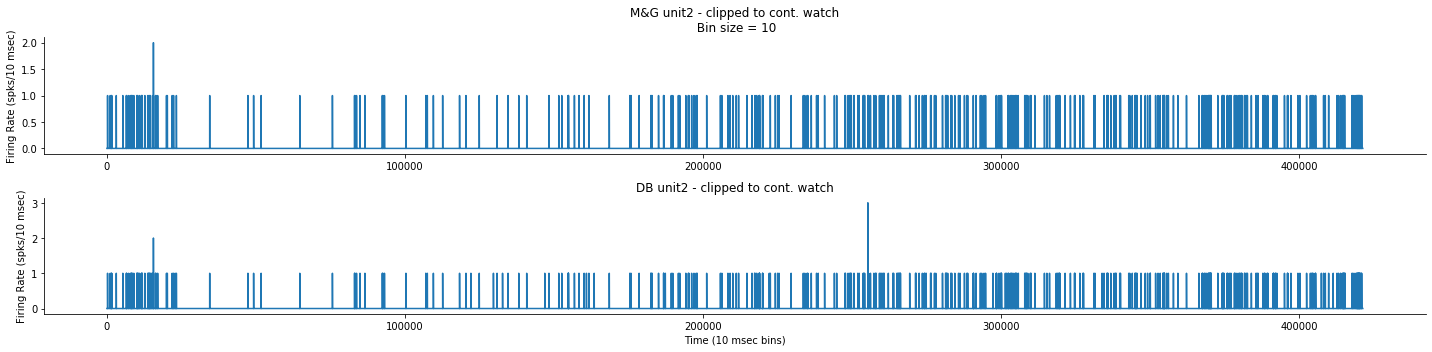

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,5))

ax1.plot(unit1_mg_clip100)
ax1.set_title("M&G unit1 - clipped to cont. watch\n Bin size = 100")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/100 msec)")


ax2.plot(unit1_db_clip100)
ax2.set_title("DB unit2 - clipped to cont. watch")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (100 msec bins)")
ax2.set_ylabel("Firing Rate (spks/100 msec)")

fig.tight_layout()

save_name = "csc6_1_cw_bin100"
plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,5))

ax1.plot(unit2_mg_clip100)
ax1.set_title("M&G unit1 - clipped to cont. watch\n Bin size = 100")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/100 msec)")

ax2.plot(unit2_db_clip100)
ax2.set_title("DB unit2 - clipped to cont. watch")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (100 msec bins)")
ax2.set_ylabel("Firing Rate (spks/100 msec)")

fig.tight_layout()

save_name = "csc6_2_cw_bin100"
plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

print("")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,5))

ax1.plot(unit1_mg_clip10)
ax1.set_title("M&G unit1 - clipped to cont. watch\n Bin size = 10")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/10 msec)")

ax2.plot(unit1_db_clip10)
ax2.set_title("DB unit1 - clipped to cont. watch")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (10 msec bins)")
ax2.set_ylabel("Firing Rate (spks/10 msec)")

fig.tight_layout()

save_name = "csc6_1_cw_bin10"
plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,5))

ax1.plot(unit2_mg_clip10)
ax1.set_title("M&G unit2 - clipped to cont. watch\n Bin size = 10")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xlabel("Time (1 sec bins)")
ax1.set_ylabel("Firing Rate (spks/10 msec)")

ax2.plot(unit2_db_clip10)
ax2.set_title("DB unit2 - clipped to cont. watch")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Time (10 msec bins)")
ax2.set_ylabel("Firing Rate (spks/10 msec)")

fig.tight_layout()

save_name = "csc6_2_cw_bin10"
plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

plt.show()

In [54]:
### 100 ###
bins = 100 # define bin size in msec
total_msec = rec_off - rec_on 
total_bins = int(total_msec / bins)
bins = np.linspace(rec_on, rec_off, total_bins)

# get times for the edges of the artifact bins
bins = bins
vec = cont_watch_100bi

cw_start = []
cw_stop = []

for ind, val in enumerate(vec):
    if val == 0: 
        cw_start.append(bins[ind])
        cw_stop.append(bins[ind + 1])
        
        
assert (len(vec) - sum(vec)) == len(cw_start)

# re-assigning start/stop variables to bin start/stops (previously pauses)
start = cw_start
stop  = cw_stop

unit1_db_cw, dbcw_rm1 = ph.rm_pauses_spikes(unit1, start, stop, return_intervals=True)
unit2_db_cw, dbcw_rm2 = ph.rm_pauses_spikes(unit2, start, stop, return_intervals=True)

cw1_spks = unit1[dbcw_rm1]
cw2_spks = unit2[dbcw_rm2]

shared_arts_cw1 = list(set(cw1_spks).intersection(artspk1))
shared_arts_cw2 = list(set(cw2_spks).intersection(artspk2))

print("Units 1 & 2")
print("Total unit1 M&G artifacts: ", len(artspk1))
print("Total unit1 spikes removed from continuous watch filtering: ", len(cw1_spks))
print("M&G artifacts also removed from continuous watch filtering: ",  len(shared_arts_cw1))
print("")

print("Total unit2 M&G artifacts: ", len(artspk2))
print("Total unit2 spikes removed from continuous watch filtering: ", len(cw2_spks))
print("M&G artifacts also removed from continuous watch filtering: ",  len(shared_arts_cw2))

Units 1 & 2
Total unit1 M&G artifacts:  714
Total unit1 spikes removed from continuous watch filtering:  1072
M&G artifacts also removed from continuous watch filtering:  171

Total unit2 M&G artifacts:  169
Total unit2 spikes removed from continuous watch filtering:  292
M&G artifacts also removed from continuous watch filtering:  134


In [53]:
# ### 10 ###

# bins = 10 # define bin size in msec
# total_msec = rec_off - rec_on 
# total_bins = int(total_msec / bins)
# bins = np.linspace(rec_on, rec_off, total_bins)

# # get times for the edges of the artifact bins
# bins = bins
# vec = cont_watch_10bi

# cw_start = []
# cw_stop = []

# for ind, val in enumerate(vec):
#     if val == 0: 
#         cw_start.append(bins[ind])
#         cw_stop.append(bins[ind + 1])
        
        
# assert (len(vec) - sum(vec)) == len(cw_start)

# # re-assigning start/stop variables to bin start/stops (previously pauses)
# start = cw_start
# stop  = cw_stop

# unit1_db_cw, dbcw_rm1 = ph.rm_pauses_spikes(unit1, start, stop, return_intervals=True)
# unit2_db_cw, dbcw_rm2 = ph.rm_pauses_spikes(unit2, start, stop, return_intervals=True)

# cw1_spks = unit1[dbcw_rm1]
# cw2_spks = unit2[dbcw_rm2]

# shared_arts_cw1 = list(set(cw1_spks).intersection(artspk1))
# shared_arts_cw2 = list(set(cw2_spks).intersection(artspk2))

# print("Units 1 & 2")
# print("Total unit1 M&G artifacts: ", len(artspk1))
# print("Total unit1 spikes removed from continuous watch filtering: ", len(cw1_spks))
# print("M&G artifacts also removed from continuous watch filtering: ",  len(shared_arts_cw1))
# print("")

# print("Total unit2 M&G artifacts: ", len(artspk2))
# print("Total unit2 spikes removed from continuous watch filtering: ", len(cw2_spks))
# print("M&G artifacts also removed from continuous watch filtering: ",  len(shared_arts_cw2))

Units 1 & 2
Total unit1 M&G artifacts:  714
Total unit1 spikes removed from continuous watch filtering:  1072
M&G artifacts also removed from continuous watch filtering:  171

Total unit2 M&G artifacts:  169
Total unit2 spikes removed from continuous watch filtering:  292
M&G artifacts also removed from continuous watch filtering:  134


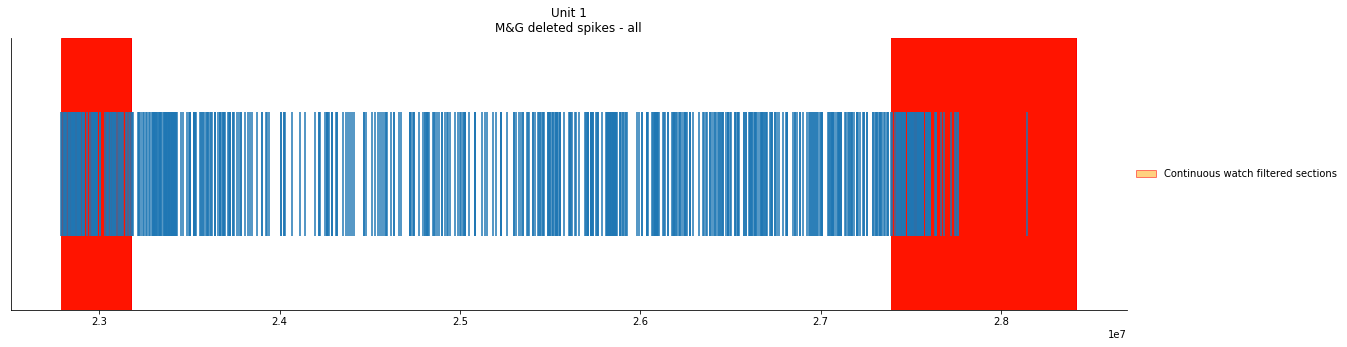

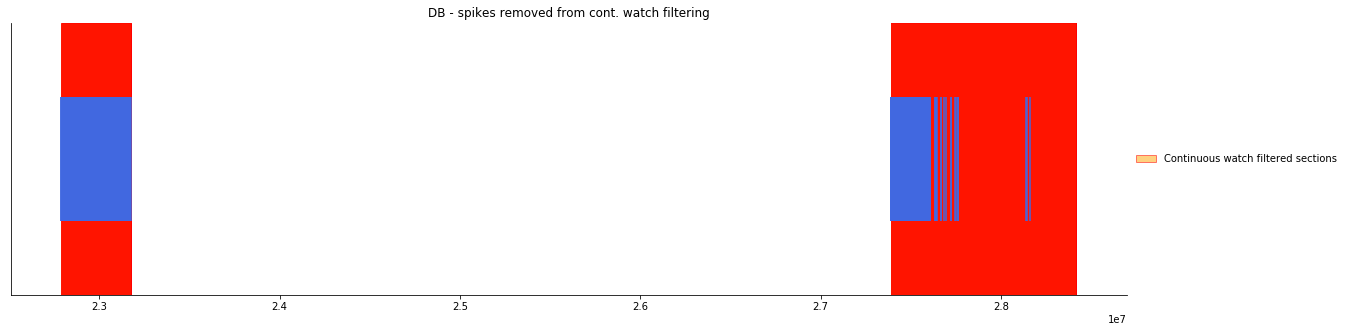

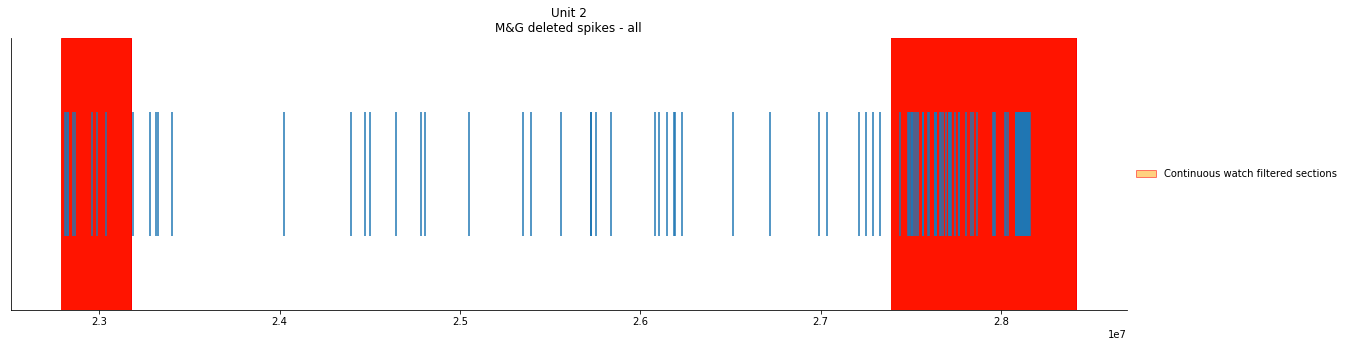

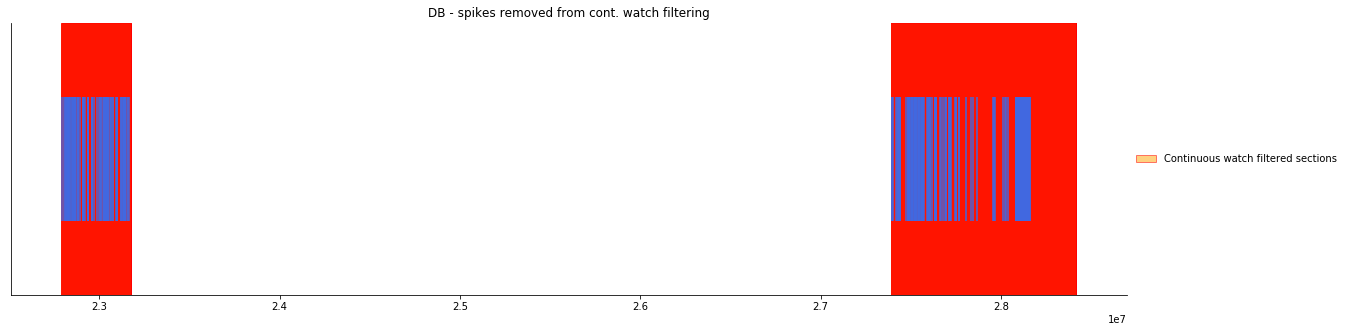

In [58]:
label = "Continuous watch filtered sections"
bin_size = 100

fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

unitnr = 1

ax1.eventplot(artspk1)
ax1.set_title("Unit {}\nM&G deleted spikes - all".format(unitnr))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_1_MGcw{}".format(bin_size)
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(cw1_spks, color="royalblue")
ax1.set_title("DB - spikes removed from cont. watch filtering")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_1_DBcw{}".format(bin_size)
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

unitnr = 2

ax1.eventplot(artspk2)
ax1.set_title("Unit {}\nM&G deleted spikes - all".format(unitnr))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_2_MGcw{}".format(bin_size)
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

ax1.eventplot(cw2_spks, color="royalblue")
ax1.set_title("DB - spikes removed from cont. watch filtering")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='orange',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

# save_name = "csc6_2_DBcw{}".format(bin_size)
# plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
# plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

## Summary

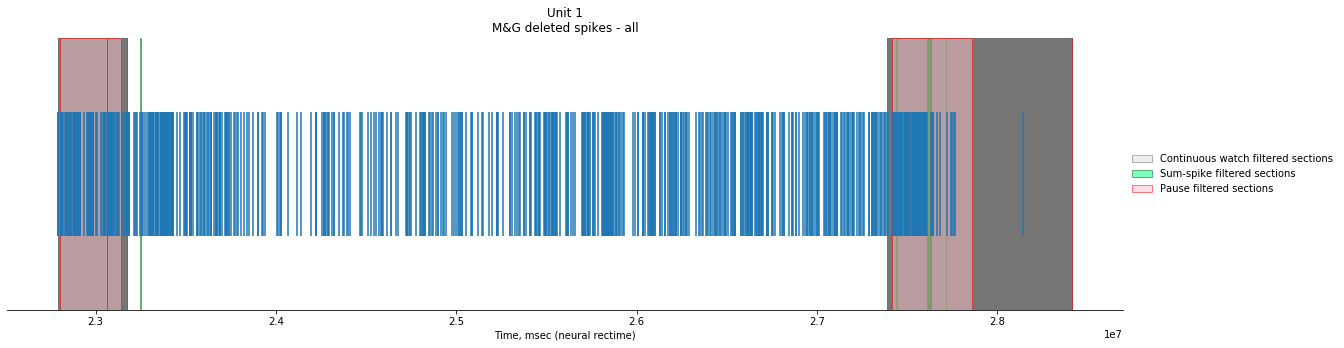

In [71]:

bin_size = 100

fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

unitnr = 1

ax1.eventplot(artspk1)
ax1.set_title("Unit {}\nM&G deleted spikes - all".format(unitnr))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_yticks([])
ax1.set_xlabel("Time, msec (neural rectime)")
## add cont watch highlights
label = "Continuous watch filtered sections"

start = cw_start
stop  = cw_stop

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='dimgray', facecolor='gainsboro',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='dimgray', facecolor='gainsboro',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

## add sum-spk highlights
label = "Sum-spike filtered sections"

start = bin_start
stop  = bin_stop

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='darkgreen', facecolor='springgreen',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='darkgreen', facecolor='springgreen',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

## add sum-spk highlights
label = "Pause filtered sections"

start = ph_start
stop  = ph_stop

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='pink',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='pink',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

save_name = "csc6_1_summary"
plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')


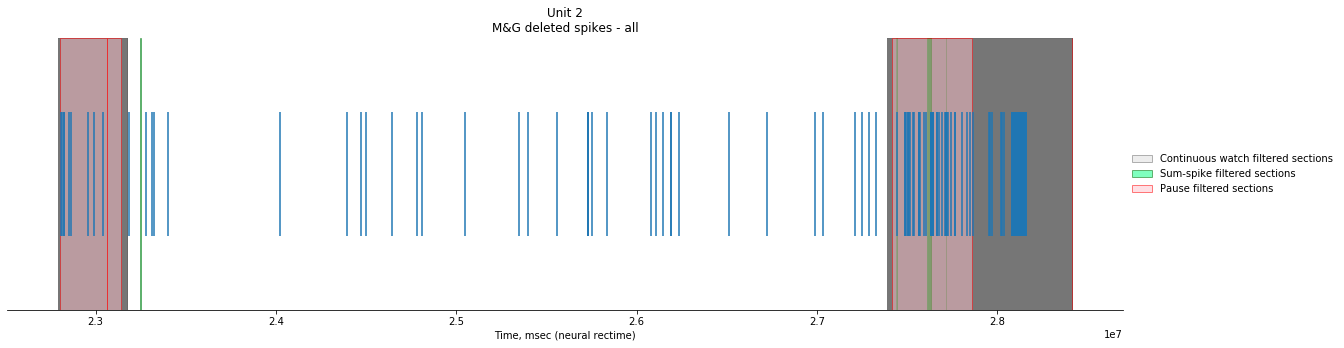

In [72]:

bin_size = 100

fig, ax1 = plt.subplots(1, 1, figsize=(20,5))

unitnr = 2

ax1.eventplot(artspk2)
ax1.set_title("Unit {}\nM&G deleted spikes - all".format(unitnr))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_yticks([])
ax1.set_xlabel("Time, msec (neural rectime)")
## add cont watch highlights
label = "Continuous watch filtered sections"

start = cw_start
stop  = cw_stop

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='dimgray', facecolor='gainsboro',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='dimgray', facecolor='gainsboro',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

## add sum-spk highlights
label = "Sum-spike filtered sections"

start = bin_start
stop  = bin_stop

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='darkgreen', facecolor='springgreen',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='darkgreen', facecolor='springgreen',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

## add sum-spk highlights
label = "Pause filtered sections"

start = ph_start
stop  = ph_stop

for i in range(len(start)): 
    if i == (len(start) - 1):
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='pink',  alpha=0.5, label=label)
    else:
        ax1.axvspan(start[i], stop[i], edgecolor='red', facecolor='pink',  alpha=0.5)
ax1.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

save_name = "csc6_2_summary"
plt.savefig(os.path.join(save_path, save_name + ".svg"), format="svg", bbox_inches='tight')
plt.savefig(os.path.join(save_path, save_name + ".png"), format="png", bbox_inches='tight')

## Put results into table

In [79]:
len(mk_comparison_vec(cw1_spks, artspk1))

714

In [110]:
len(artspk2)

169

In [88]:
results1 = pd.DataFrame()
results1['unit1_all'] = artspk1
results1['unit1_cw']  = mk_comparison_vec(cw1_spks, artspk1)
results1['unit1_ss']  = mk_comparison_vec(ss1_spks, artspk1)
results1['unit1_ph']  = mk_comparison_vec(ph1_spks, artspk1)

results2 = pd.DataFrame()
results2['unit2_all'] = artspk2
results2['unit2_cw']  = mk_comparison_vec(cw2_spks, artspk2)
results2['unit2_ss']  = mk_comparison_vec(ss2_spks, artspk2)
results2['unit2_ph']  = mk_comparison_vec(ph2_spks, artspk2)

In [91]:
print("results summary, unit1:")
print(sum(results1['unit1_cw']))
print(sum(results1['unit1_ss']))
print(sum(results1['unit1_ph']))

print("results summary, unit2:")
print(sum(results2['unit2_cw']))
print(sum(results2['unit2_ss']))
print(sum(results2['unit2_ph']))

results summary, unit1:
171
0
161
results summary, unit2:
134
4
65


In [92]:
import matplotlib_venn as mvp

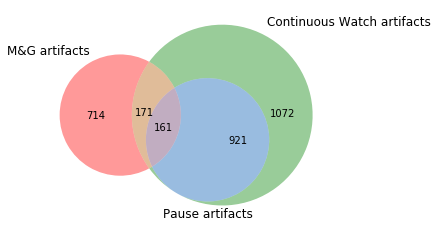

In [104]:
venn1 = mvp.venn3(subsets = (len(artspk1), len(cw1_spks), sum(results1['unit1_cw']),
                len(ss1_spks), sum(results1['unit1_ss']), 
                len(ph1_spks), sum(results1['unit1_ph'])), set_labels = ('M&G artifacts', 'Continuous Watch artifacts', 'Pause artifacts'))

filename = "csc6_1_venn.svg"
plt.savefig(os.path.join(save_path, filename), format="svg", bbox_inches="tight")

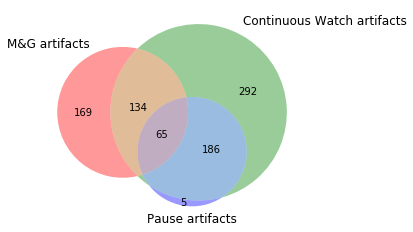

In [107]:
venn2 = mvp.venn3(subsets = (len(artspk2), len(cw2_spks), sum(results2['unit2_cw']),
                len(ss2_spks), sum(results2['unit2_ss']), 
                len(ph2_spks), sum(results2['unit2_ph'])), set_labels = ('M&G artifacts', 'Continuous Watch artifacts', 'Pause artifacts'))

filename = "csc6_2_venn.svg"
plt.savefig(os.path.join(save_path, filename), format="svg", bbox_inches="tight")